### Comparing the models Performance

#### Import required  libraries
* install the below packages if missing

```bash
    %pip install pandas numpy tensorflow scikit-learn plotly matplotlib
```

In [307]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

#### Data Preparation 

####  1.1 Set the stock symbol

In [308]:
stock='GOOG'
time_step=15

#####  1.2 Method to create data sets with lags

In [309]:
def create_dataset(data, lag=1):
    """ method to create data sets with lags
    Args:
        data (_type_):  DataFrame
        lag (int, optional): Lag time. Defaults to 1.

    Returns:
        X,y,indices: Returns the X with lag from current time step  t to t-lag
    """
    X, y = [], []
    for i in range(len(data) - lag):
        X.append(data[i:(i + lag), 0])
        y.append(data[i + lag, 0])
    return np.array(X), np.array(y)

In [310]:
def create_dataset_WithEarnings(data, earnings, lag=1):
    X, y = [], []
    for i in range(len(data) - lag):
        delta=data[i:(i + lag), 0]
        delta=np.append(delta, earnings[i + lag, 0])
        X.append(delta)
        y.append(data[i + lag, 0])
    return np.array(X), np.array(y)

#### 1.3 Create Test ans train Data set
*  Get the weekly data 
*  We will use the Adjusted Close
*  Normalize with Min Max Scaler
*  Create Data Set with lag
*  Set the split 

In [311]:
df_stock = pd.read_csv(f'./data/{stock}_weekly_adjusted.csv', header=0, index_col=0, parse_dates=[0], thousands=',')
ddf_stock=df_stock.sort_index(ascending=True,inplace=True) ## As the Data is in Descending order

ts = df_stock['Adjusted Close'].values

# Use the 'Adjusted Close' prices for analysis
ts = df_stock['Adjusted Close'].values


In [312]:
from datetime import datetime, timedelta
earnings_df = pd.read_csv(f'./data/{stock}_earnings.csv', header=0, index_col=0, parse_dates=[0,1], thousands=',')
earnings_df=earnings_df.sort_index(ascending=True)        
earnings_df['endDate']=earnings_df['reportedDate'].shift(-1)
current_datetime = datetime.now()
# Convert the current datetime to pandas.Timestamp
current_timestamp = pd.Timestamp(current_datetime)
earnings_df.iloc[-1,-1]= current_timestamp ## Till Date

In [313]:


def generate_weekly_earnings(earnings_df, df_stock):
    # Parse weekly prices into dates for mapping
    weekly_dates = df_stock.index.values
    
    # Map earnings to weeks
    weekly_earnings = {}
    for i in earnings_df.values:
        start_date = i[0]
        end_date = i[6]
        # print(start_date,end_date)
        # Filter weeks that fall within the quarter
        relevant_weeks = [date for date in weekly_dates if start_date <= date <= end_date]
        # print(relevant_weeks)
        if relevant_weeks:
            # Calculate weekly earnings by evenly dividing quarterly earnings
            for week in relevant_weeks:
                weekly_earnings[str(week)] = i[4]
    
    # Assign weekly earnings to the weekly prices
    weekly_earnings_result = [weekly_earnings.get(str(week), 0) for week in df_stock.index.values]
    return weekly_earnings_result

    

In [314]:
df_stock['earnings']=generate_weekly_earnings(earnings_df, df_stock)

In [315]:


# Normalize the actual prices
scaler = MinMaxScaler()
ts = ts.reshape(-1, 1)  # Reshape for scaler
ts_scaled = scaler.fit_transform(ts)

earningsScaler=MinMaxScaler()
earnings=df_stock['earnings'].values.reshape(-1, 1)
earnings_scaled=earningsScaler.fit_transform(earnings)

# Set time step for LSTM
# time_step = 10  # Number of previous days to use for predicting the next day
X, y = create_dataset_WithEarnings(ts_scaled,earnings_scaled, time_step)


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### 1.4 Print the Shape of Test and Train Data

In [316]:
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(432, 16) (108, 16)
(432,) (108,)


In [317]:
X_train

array([[0.13829966, 0.14420839, 0.14743199, ..., 0.16437655, 0.18105516,
        0.68347904],
       [0.16144284, 0.16309238, 0.14440306, ..., 0.19303195, 0.20562087,
        0.70296737],
       [0.8590739 , 0.84106919, 0.83718135, ..., 0.88587672, 0.92906168,
        0.68166828],
       ...,
       [0.17024395, 0.17601253, 0.18692556, ..., 0.21173624, 0.22208147,
        0.74893228],
       [0.5581179 , 0.58458591, 0.55752014, ..., 0.36979138, 0.42971844,
        0.49652482],
       [0.07212546, 0.07143845, 0.07580307, ..., 0.05841888, 0.05349004,
        0.55506748]])

### Base Line Model With Ridge 

#### 2.1  Find the best fit for alpha

In [318]:
# RidgeCV performs cross-validation to find the best alpha
alphas = np.logspace(-6, 6, 13)  # A range of alpha values to try
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)

# Fit the model
ridge_cv.fit(X_train, y_train)

# Best alpha found via cross-validation
print(f'Best alpha: {ridge_cv.alpha_}')

Best alpha: 0.01


/Users/manikandanperumal/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning:

'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.



#### 2.2 Train and Test model

In [319]:
# Build the Ridge model
ridge = Ridge(alpha=0.01)  # alpha is the regularization strength; higher alpha means stronger regularization

# Train the model
ridge.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ridge.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.00038600824109020414


#### 2.3 Capture the predictions into a Data Frame

In [320]:
inp=pd.DataFrame(X.reshape(X.shape[0],X.shape[1]))
columns=[f'lag_{time_step-i}' for i in range(time_step)]
columns.append('earnings')
inp.columns=columns
inp['observed']=y
inp['ridge_predicted']=ridge.predict(X)
temp=inp['earnings']
inp=inp.drop(columns=['earnings'])
inp_scaled=scaler.inverse_transform(inp)

# inp_scaled['date']=dates
result_df=pd.DataFrame(inp_scaled)
result_df['earnings']=earningsScaler.inverse_transform([temp]).reshape(1,-1)[0]
result_df.columns=[*inp.columns,'earnings']

result_df

,lag_15,lag_14,lag_13,lag_12,lag_11,lag_10,lag_9,lag_8,lag_7,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1,observed,ridge_predicted,earnings
0,27.0901,26.4646,26.7389,25.7454,26.3314,25.8726,25.9673,27.5669,27.9255,27.7479,27.5200,27.7494,28.7909,29.1644,28.8876,29.6807,29.193048,-7.4581
1,26.4646,26.7389,25.7454,26.3314,25.8726,25.9673,27.5669,27.9255,27.7479,27.5200,27.7494,28.7909,29.1644,28.8876,29.6807,29.3784,29.781634,-7.4581
2,26.7389,25.7454,26.3314,25.8726,25.9673,27.5669,27.9255,27.7479,27.5200,27.7494,28.7909,29.1644,28.8876,29.6807,29.3784,28.2337,29.693404,-7.4581
3,25.7454,26.3314,25.8726,25.9673,27.5669,27.9255,27.7479,27.5200,27.7494,28.7909,29.1644,28.8876,29.6807,29.3784,28.2337,28.3684,28.990519,-7.4581
4,26.3314,25.8726,25.9673,27.5669,27.9255,27.7479,27.5200,27.7494,28.7909,29.1644,28.8876,29.6807,29.3784,28.2337,28.3684,28.6033,28.416169,-7.4581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,191.7036,186.5305,179.1504,168.4547,168.1751,165.1691,164.5200,167.2064,164.8895,151.9268,158.3700,164.6400,165.2900,168.5600,164.5200,165.0500,164.459430,2.7174
536,186.5305,179.1504,168.4547,168.1751,165.1691,164.5200,167.2064,164.8895,151.9268,158.3700,164.6400,165.2900,168.5600,164.5200,165.0500,166.9900,165.689332,2.7174
537,179.1504,168.4547,168.1751,165.1691,164.5200,167.2064,164.8895,151.9268,158.3700,164.6400,165.2900,168.5600,164.5200,165.0500,166.9900,172.6500,166.898732,14.5946
538,168.4547,168.1751,165.1691,164.5200,167.2064,164.8895,151.9268,158.3700,164.6400,165.2900,168.5600,164.5200,165.0500,166.9900,172.6500,179.8600,172.115531,14.5946


##### Plot the predictions for Ridge


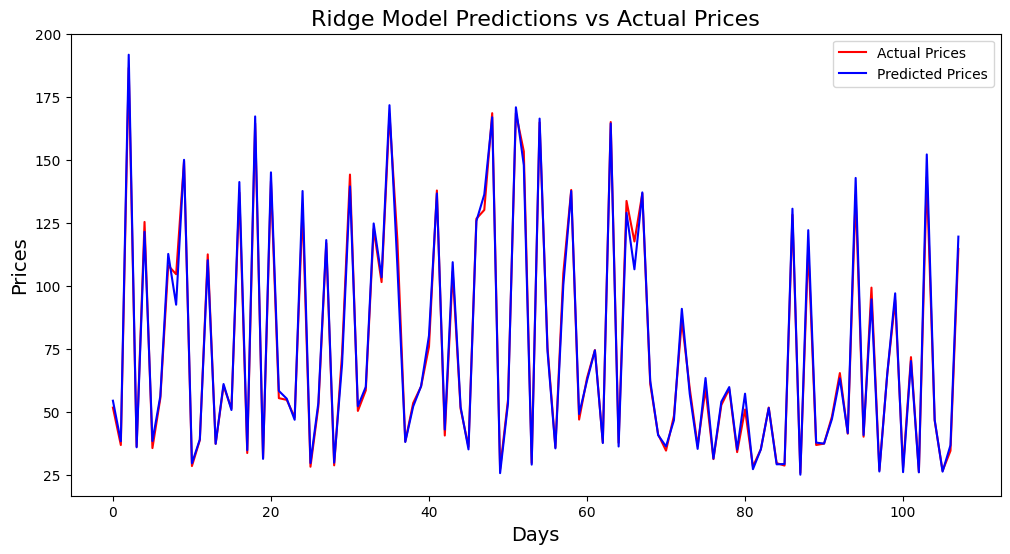

In [321]:
# Make predictions
predictions = ridge.predict(X_test)

# Inverse transform to get the original scale for predicted prices
predictions = scaler.inverse_transform(predictions.reshape(1,-1)).reshape(-1,1)

# Inverse transform actual test prices
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))


# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_scaled, label='Actual Prices', color='red')
plt.plot(predictions, label='Predicted Prices', color='blue')
plt.title('Ridge Model Predictions vs Actual Prices', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Prices', fontsize=14)
plt.legend()
plt.show()

####  Plotly interactive visualization
- Helps to zoom in and zoom out
- We can see the best prediction is biased towards the previous week price


In [322]:
import plotly.express as px
import plotly.graph_objects as go

trace1 = go.Scatter(x=dates[-len(y_test_scaled):], y=y_test_scaled.reshape(1,-1)[0], mode='lines', name='Stock Price')
trace2 = go.Scatter(x=dates[-len(y_test_scaled):], y=predictions.reshape(1,-1)[0], mode='lines', name='predicted')

# Create the layout
layout = go.Layout(
    title='Stock Price and  Ridge Prediction Over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Value')
)

# Create the figure with both traces
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show the plot
fig.show()


#### LSTM 

#### 3.1 Build the model

In [323]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(tf.keras.layers.LSTM(50, return_sequences=False))
model.add(tf.keras.layers.Dense(25))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

/Users/manikandanperumal/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



#### 3.2 Change the shape for data set

In [324]:
X_train_in = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_in =X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

##### 3.3 Train and Test the model

In [325]:
# Fit the model
model.fit(X_train_in, y_train, batch_size=32, epochs=100,verbose=False)

# Make predictions
predictions = model.predict(X_test_in)

# Inverse transform to get the original scale for predicted prices
predictions_scaled = scaler.inverse_transform(predictions)

# Inverse transform actual test prices
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))


# Evaluate the model performance
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mean Squared Error: 0.0007537915465487274


#### Capture the predictions in data frame and combine with Ridge model

In [326]:
X_in= X.reshape(X.shape[0], X.shape[1], 1)
lstm_pred=model.predict(X_in)
lstm_pred_scaled=scaler.inverse_transform(lstm_pred)
result_df['lstm_predicted']=lstm_pred_scaled

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [327]:
result_df

,lag_15,lag_14,lag_13,lag_12,lag_11,lag_10,lag_9,lag_8,lag_7,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1,observed,ridge_predicted,earnings,lstm_predicted
0,27.0901,26.4646,26.7389,25.7454,26.3314,25.8726,25.9673,27.5669,27.9255,27.7479,27.5200,27.7494,28.7909,29.1644,28.8876,29.6807,29.193048,-7.4581,30.341558
1,26.4646,26.7389,25.7454,26.3314,25.8726,25.9673,27.5669,27.9255,27.7479,27.5200,27.7494,28.7909,29.1644,28.8876,29.6807,29.3784,29.781634,-7.4581,30.632978
2,26.7389,25.7454,26.3314,25.8726,25.9673,27.5669,27.9255,27.7479,27.5200,27.7494,28.7909,29.1644,28.8876,29.6807,29.3784,28.2337,29.693404,-7.4581,30.880529
3,25.7454,26.3314,25.8726,25.9673,27.5669,27.9255,27.7479,27.5200,27.7494,28.7909,29.1644,28.8876,29.6807,29.3784,28.2337,28.3684,28.990519,-7.4581,30.981665
4,26.3314,25.8726,25.9673,27.5669,27.9255,27.7479,27.5200,27.7494,28.7909,29.1644,28.8876,29.6807,29.3784,28.2337,28.3684,28.6033,28.416169,-7.4581,31.015142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,191.7036,186.5305,179.1504,168.4547,168.1751,165.1691,164.5200,167.2064,164.8895,151.9268,158.3700,164.6400,165.2900,168.5600,164.5200,165.0500,164.459430,2.7174,162.987305
536,186.5305,179.1504,168.4547,168.1751,165.1691,164.5200,167.2064,164.8895,151.9268,158.3700,164.6400,165.2900,168.5600,164.5200,165.0500,166.9900,165.689332,2.7174,163.708618
537,179.1504,168.4547,168.1751,165.1691,164.5200,167.2064,164.8895,151.9268,158.3700,164.6400,165.2900,168.5600,164.5200,165.0500,166.9900,172.6500,166.898732,14.5946,166.324799
538,168.4547,168.1751,165.1691,164.5200,167.2064,164.8895,151.9268,158.3700,164.6400,165.2900,168.5600,164.5200,165.0500,166.9900,172.6500,179.8600,172.115531,14.5946,168.129852


In [328]:
from xgboost import XGBRFRegressor
model = XGBRFRegressor(use_label_encoder=False, eval_metric='logloss')

model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[23:49:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric='logloss', feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=None, reg_alpha=None, ...)

In [329]:
y_pred=model.predict(X)
y_pred_inv_scaled=scaler.inverse_transform(np.reshape(y_pred,[-1,1]))
y_pred_inv_scaled.reshape(1,-1)[0]
result_df['xgb_predicted']=y_pred_inv_scaled.reshape(1,-1)[0]

#### utility method to get metrics across multiple moodel

In [330]:

def accuracy(df_forecast, y_train_series, seasonallity):

    method = df_forecast.columns[1:]
    rmse_results = []
    mae_results = []
    mape_results = []
    mase_results = []
    dir_accuracy_results=[]
    
    def directional_accuracy(y_true, y_pred):
    # Compare directions of changes
        y_true_dir = np.sign(np.diff(y_true))
        y_pred_dir = np.sign(np.diff(y_pred))
        return np.mean(y_true_dir == y_pred_dir)

    y = df_forecast.observed.values
    scale = np.abs(y_train_series[:-seasonallity] - y_train_series[seasonallity:])
    scale = np.average(scale)

    for i in method:
        y_hat = df_forecast[i].values
        d = y - y_hat
        mae_f = np.mean(abs(d))
        rmse_f = np.sqrt(np.mean(d**2))
        mape = np.mean(np.abs(d/y))*100
        mase = mae_f / scale
        dir_accuracy=directional_accuracy(y,y_hat)
        mae_results.append(np.round(mae_f,2))
        rmse_results.append(np.round(rmse_f,2))
        mape_results.append(np.round(mape,2))
        mase_results.append(np.round(mase,2))
        dir_accuracy_results.append(np.round(dir_accuracy,2))

    accuracy_df = pd.DataFrame({'Method':method,
                    'RMSE':rmse_results,
                    'MAE':mae_results,
                    'MAPE':mape_results,
                    'MASE':mase_results,
                   'DA':dir_accuracy_results })

    return accuracy_df

#### Compare the performance of the models

* DA - Directional Accuracy 
    * All the models have accuracy < 0.5 except xgboost
    * still Not a great fit

In [331]:

accuracy(result_df[['observed','lag_1','ridge_predicted','lstm_predicted','xgb_predicted']], result_df['observed'].values, time_step)

,Method,RMSE,MAE,MAPE,MASE,DA
0,lag_1,3.51,2.33,2.82,0.27,0.48
1,ridge_predicted,3.37,2.29,2.87,0.26,0.48
2,lstm_predicted,4.61,3.34,4.40,0.38,0.52
3,xgb_predicted,2.31,1.51,1.98,0.17,0.67


#### Visualizing all the model predictions

In [332]:
import plotly.express as px
import plotly.graph_objects as go

trace1 = go.Scatter(x=df_stock.index[time_step:], y=result_df['observed'], mode='lines', name='Stock Price')
trace2 = go.Scatter(x=df_stock.index[time_step:], y=result_df['lag_1'], mode='lines', name='lag 1')
trace3 = go.Scatter(x=df_stock.index[time_step:], y=result_df['ridge_predicted'], mode='lines', name='ridge predicted')
trace4 = go.Scatter(x=df_stock.index[time_step:], y=result_df['lstm_predicted'], mode='lines', name='lstm predicted')
trace5 = go.Scatter(x=df_stock.index[time_step:], y=result_df['xgb_predicted'], mode='lines', name='xgboost predicted')

# Create the layout
layout = go.Layout(
    title='Stock Price and Prediction Over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Value')
)

# Create the figure with both traces
fig = go.Figure(data=[trace1, trace2,trace3,trace4,trace5], layout=layout)

# Show the plot
fig.show()

In [335]:
result_df[['earnings','observed','ridge_predicted','lstm_predicted','xgb_predicted']].tail(20)

,earnings,observed,ridge_predicted,lstm_predicted,xgb_predicted
520,25.1656,191.7036,182.008556,180.495575,188.858688
521,25.1656,186.5305,191.760210,183.949203,181.791687
522,25.1656,179.1504,187.700388,185.991165,180.322113
523,2.7174,168.4547,179.912501,181.744354,168.080872
524,2.7174,168.1751,171.731824,177.864914,166.116348
525,2.7174,165.1691,168.244429,173.622223,164.705490
526,2.7174,164.5200,167.273094,169.063400,165.119965
527,2.7174,167.2064,166.232378,165.422485,165.594345
528,2.7174,164.8895,166.408446,163.624130,162.994949
529,2.7174,151.9268,165.363489,162.425842,156.243027
